# Gaussian Procceses

* So, Gaussian processes came up initially when we were looking at interpolation.
* We wanted a way of interpolating between points but with some uncertainty on our value.
* So lets take a quick recap to interpolation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mn
import seaborn as sb
cs = ['#56d870', '#f9ee4a', '#44d9ff', '#f95b4a', '#3d9fe2', '#ffa847', '#c4ef7a', '#e195e2', '#ced9ed', '#fff29b']

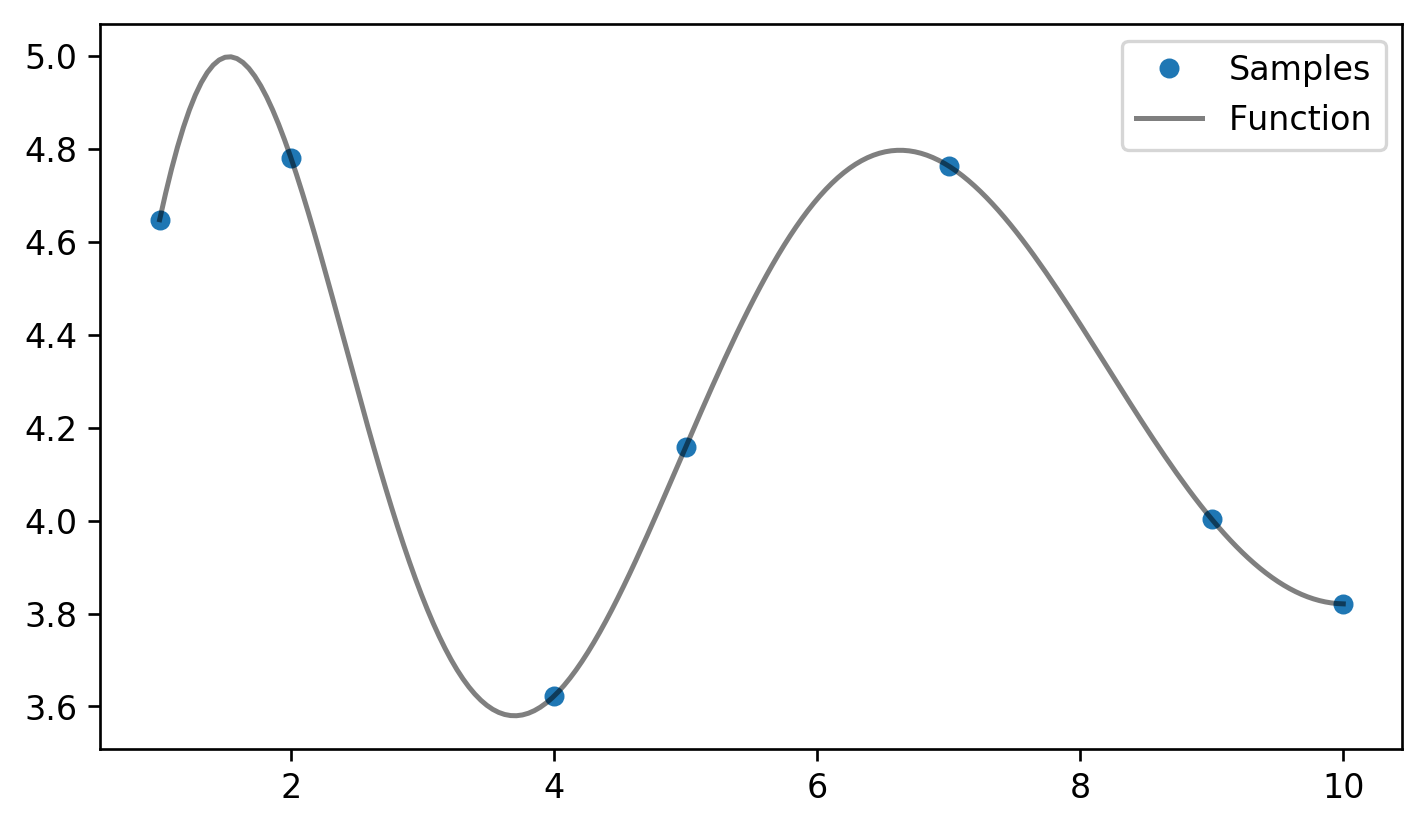

In [10]:
def fn(xs):
    return np.exp((xs + 10.5)**0.1) + np.sin(xs) / (xs + 1) + np.cos(2.5 * xs**0.5)**2

xs = np.array([1, 2, 4, 5, 7, 9, 10])
ys = fn(xs)
x_fine = np.linspace(1, 10, 200)
y_fine = fn(x_fine)

plt.plot(xs, ys, 'o', label="Samples", markersize=5)
plt.plot(x_fine, y_fine, label="Function", color="k", alpha=0.5, linestyle="-")
plt.legend();

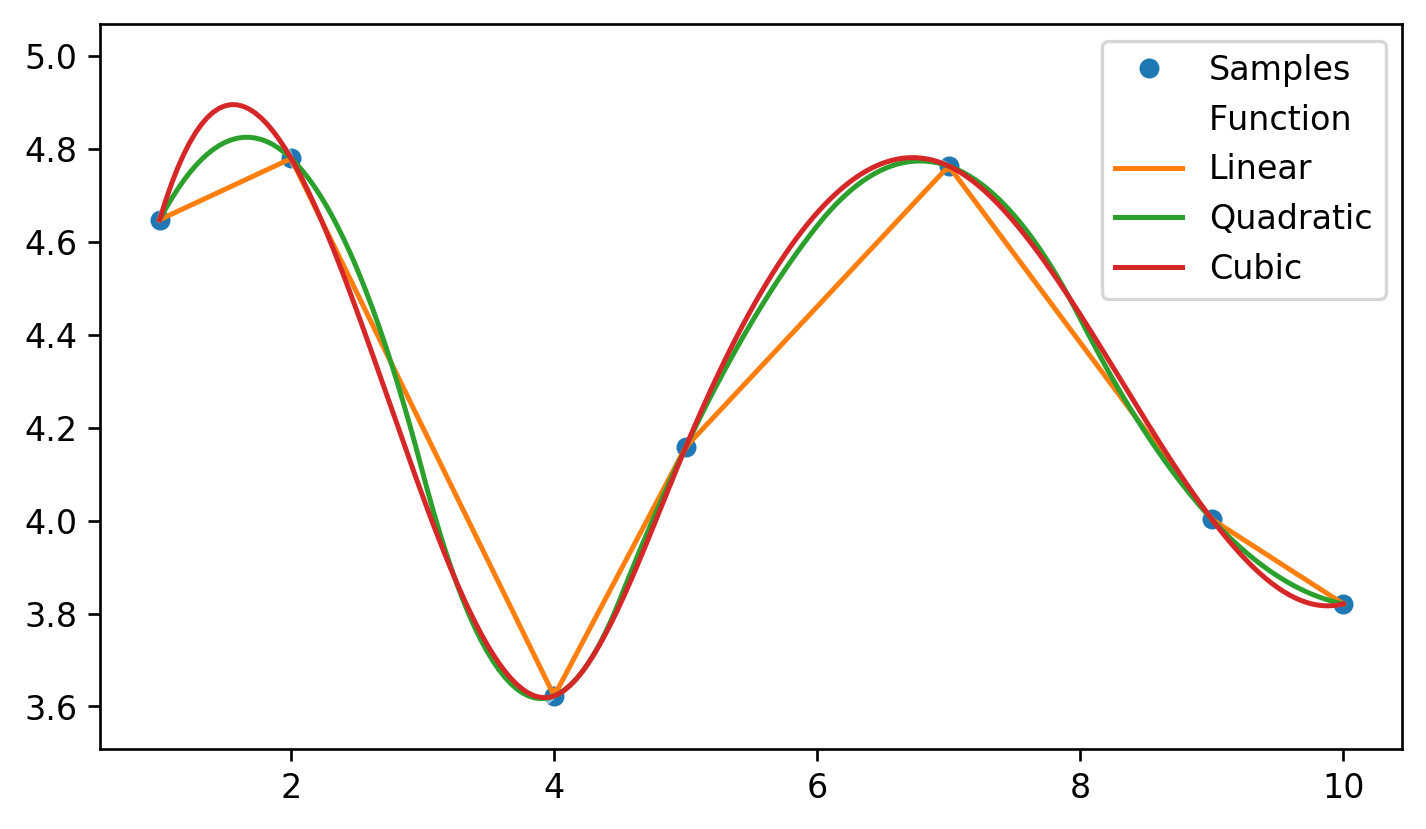

In [3]:
from scipy.interpolate import interp1d

y_linear = interp1d(xs, ys, kind="linear")(x_fine)
y_quad = interp1d(xs, ys, kind="quadratic")(x_fine)
y_cubic = interp1d(xs, ys, kind="cubic")(x_fine)

plt.plot(xs, ys, 'o', label="Samples", markersize=5)
plt.plot(x_fine, y_fine, label="Function", color="w", ls="-", alpha=0.5)
plt.plot(x_fine, y_linear, label="Linear")
plt.plot(x_fine, y_quad, label="Quadratic")
plt.plot(x_fine, y_cubic, label="Cubic")
plt.legend();

So lots of different interpolation options. Nothing the looks like what we want. So now, for an aside, lets create a highly correlated covariance matrix.

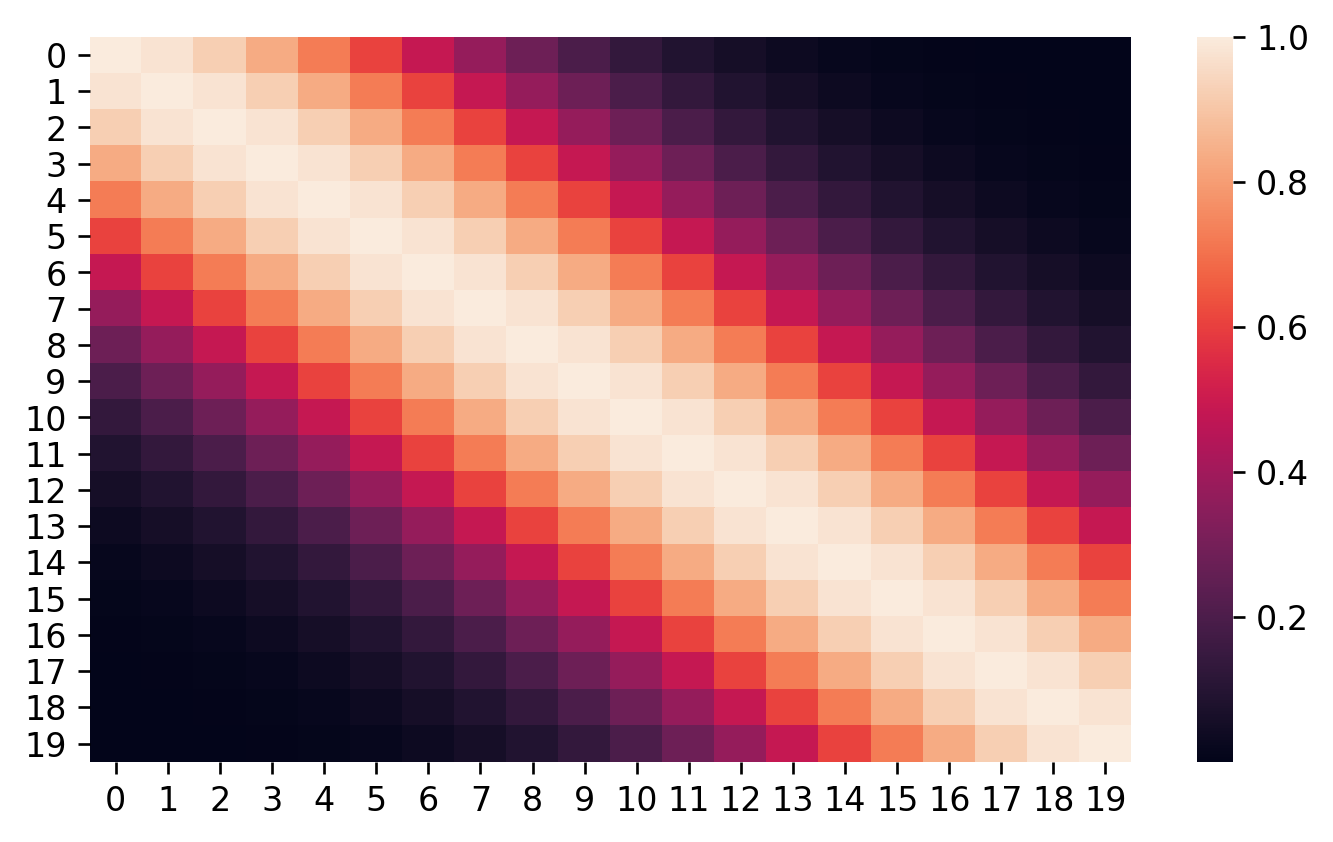

In [4]:
x = np.arange(20)
length = 50
cov = np.exp(-(1 / length) * (x - np.atleast_2d(x).T)**2)
sb.heatmap(cov);

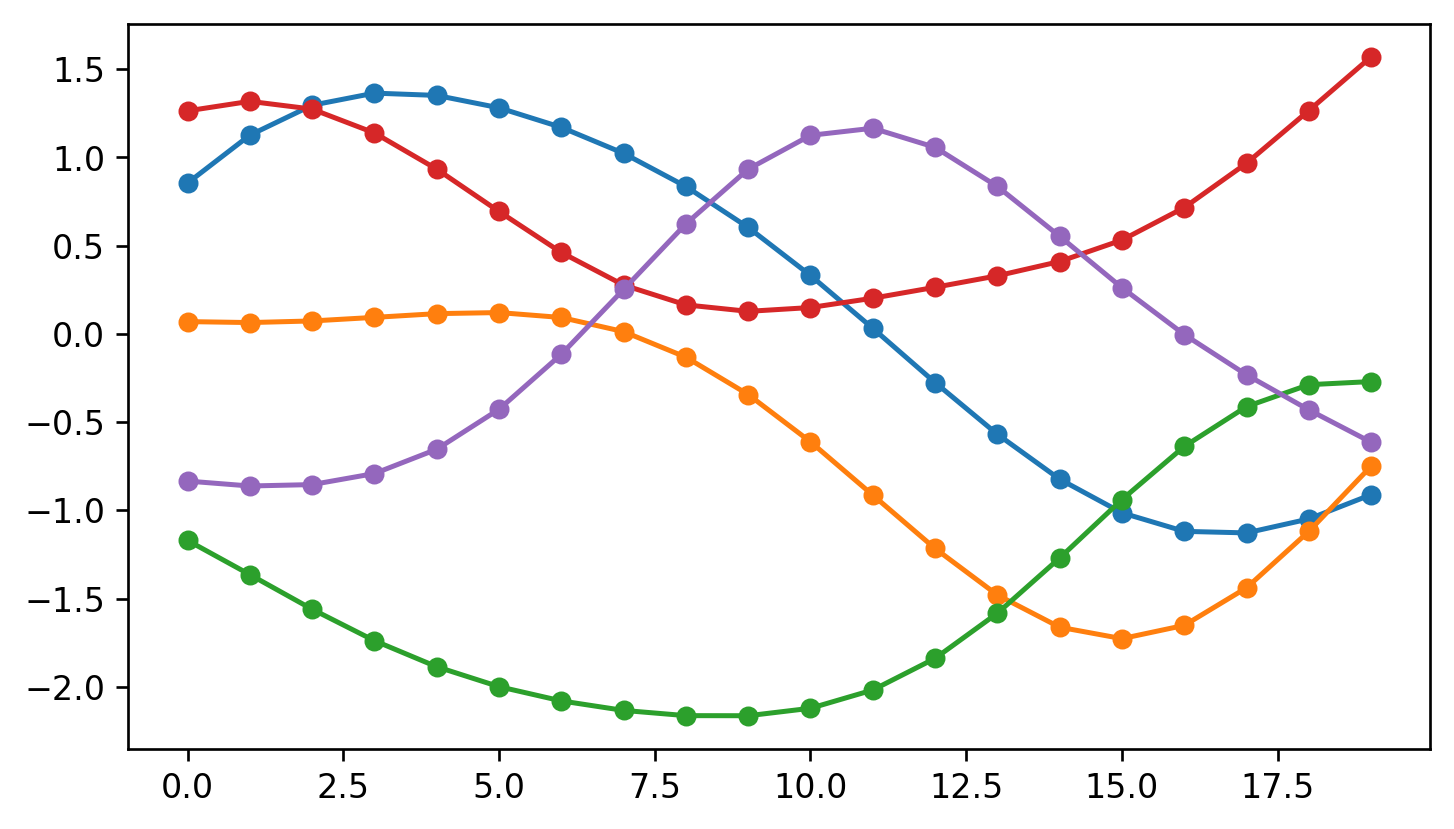

In [5]:
for i in range(5):
    rvs = mn.rvs(cov=cov)
    plt.plot(x, rvs, 'o-', ms=5)

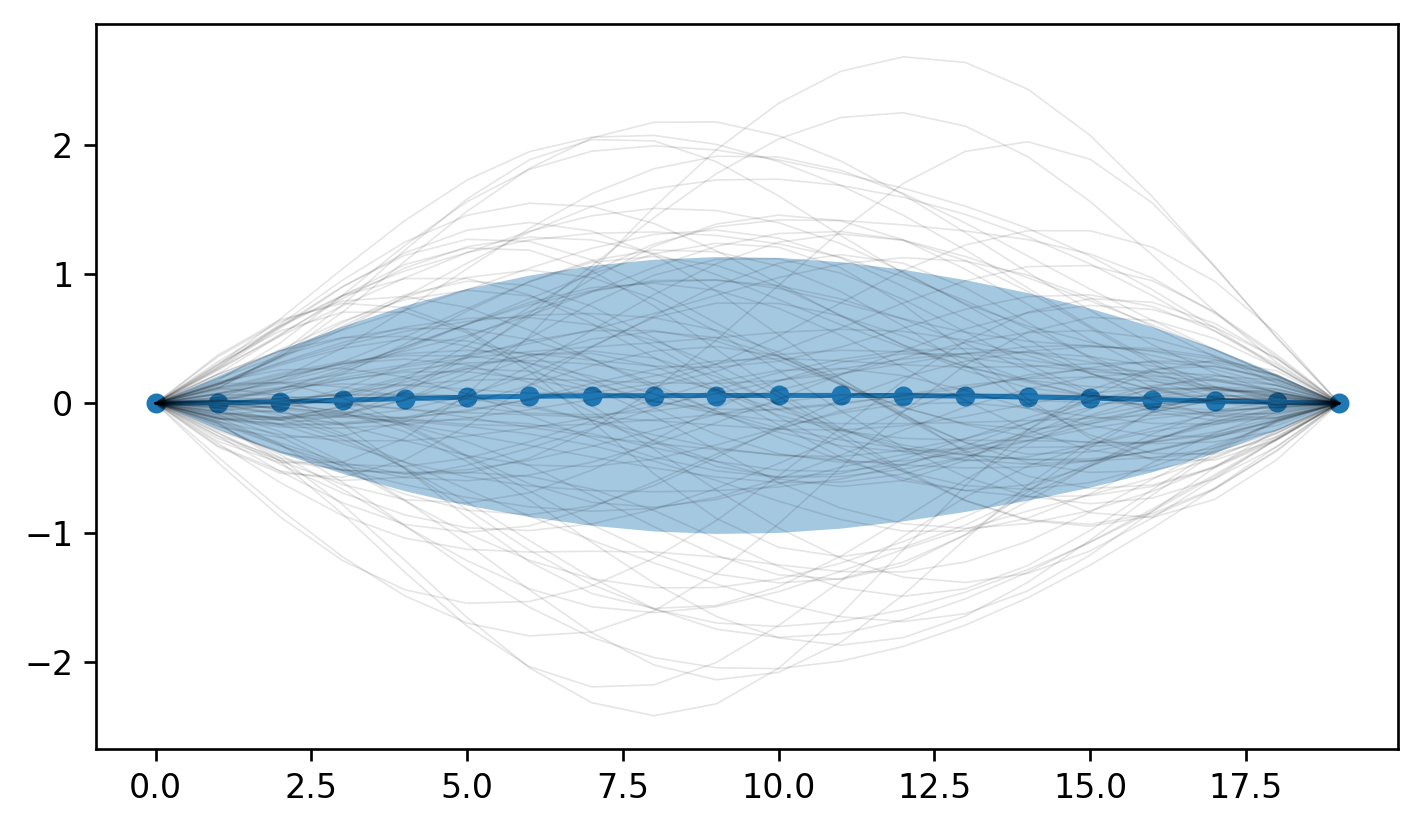

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

rvs = mn.rvs(cov=cov, size=200)
rvs -= np.linspace(rvs[:, 0], rvs[:, -1], x.size).T  # Conceptual aid, not how you'd actually do it

mean = rvs.mean(axis=0)
std = np.std(rvs, axis=0)

plt.plot(x, mean, "o-", ms=5)
plt.fill_between(x, mean + std, mean - std, alpha=0.4)
for i in range(100):
    plt.plot(x, rvs[i, :], ls="-", c="k", alpha=0.1, lw=0.5)


In the above pseudo-GP process we wanted to interpolate 20 points (well 18 'unknown' points given the ends are fixed), and so we did this by drawing from a 20-D Gaussian. But obviously there are an infinite number of points we might want to interpolate to, so we'd draw from an infinite-dimensional Gaussian. This is what "non-parametric" means - infinite dimensions.

And by drawing over and over we can come up with some mean prediction and some standard deviation on it. Note that this is dependent on our choice for covariance. The cov we have used has only one parameter, its length scale. The larger $l$ gets the smoother and less changing the predictions become. This number that we 'pick' is known as a hyperparameter. And its something we have to fit for when creating a real GP. And in terms of nomenclature, moving from a MVGaussian to a Gaussian process we dont have a mean, we have a mean function (because we can ask for the mean at any x). Similarly the covariance matrix depends on the input data points (in our previous example we didnt have any, just hack fixed the first and last point) and the points we want to evaluate at, so we have a covariance function. The shape of the covariance (ie we had squared distance) is called the kernel (you can have different functions, squared distance is just a useful one)

### Gaussian Proccesses

Interpolation on steroids. For this section, you'll need sklearn. `pip install sklearn` if you don't have it.

Gaussian procces work by training a model, which is fitting the hyperparameters of the specific kernel that you provide.  The difficulty is in knowing what kernel to construct and then let the model train. This kernel essentially relates how every data point affects regions in parameter space. 

All this kernel says is that if you are interpolating at point x, which lies between point A and point B, you determine how much A contributes (but taking $\exp(-(x-A)^2/(2\sigma)^2)$) and then do the same for B. You get a different weight for A and B, and you use that to compute what you think the value at x is. The training part of this is to find the best value of $\sigma$ in the kernel that gives the best results.

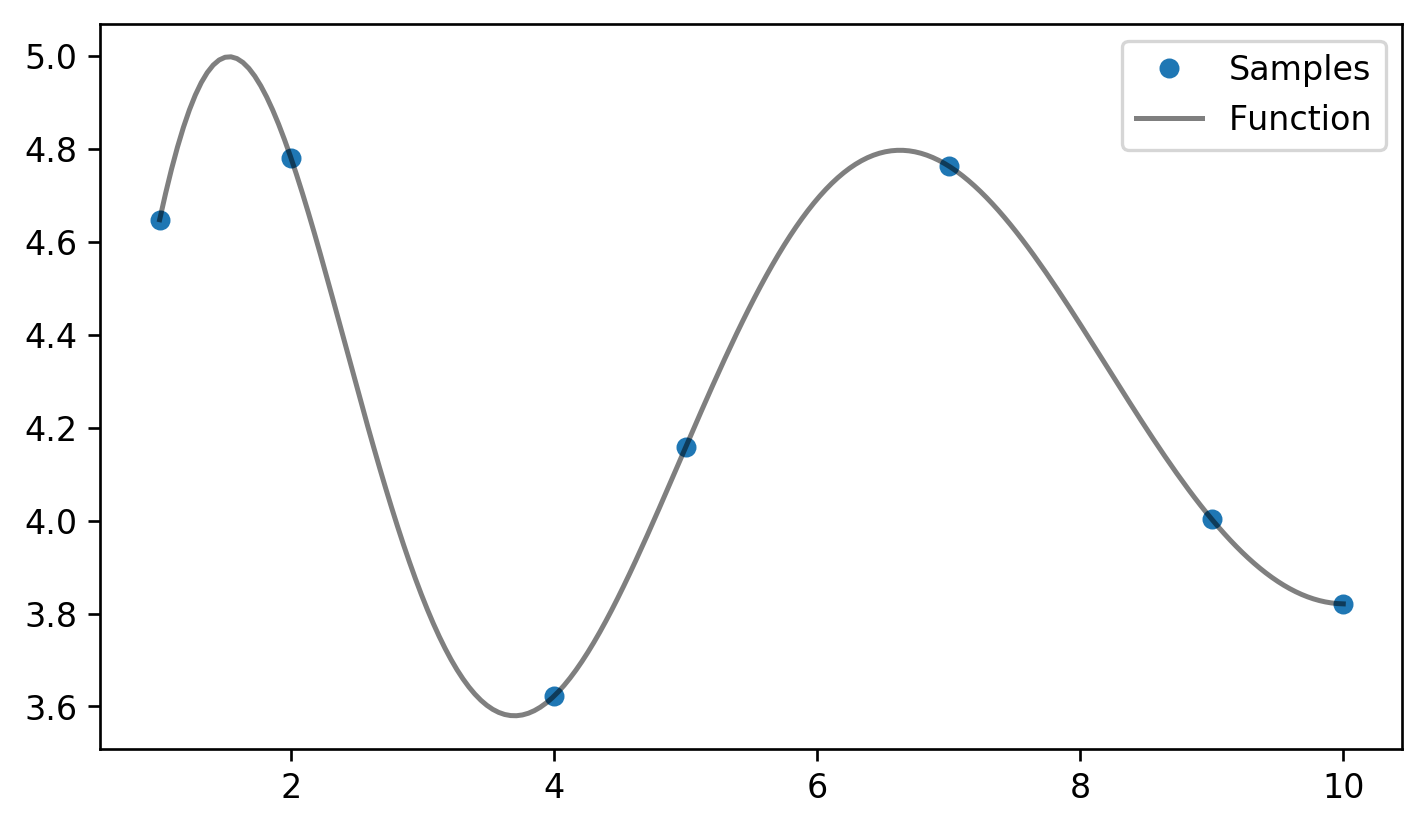

In [11]:
plt.plot(xs, ys, 'o', label="Samples", markersize=5)
plt.plot(x_fine, y_fine, label="Function", color="k", ls="-", alpha=0.5)
plt.legend();

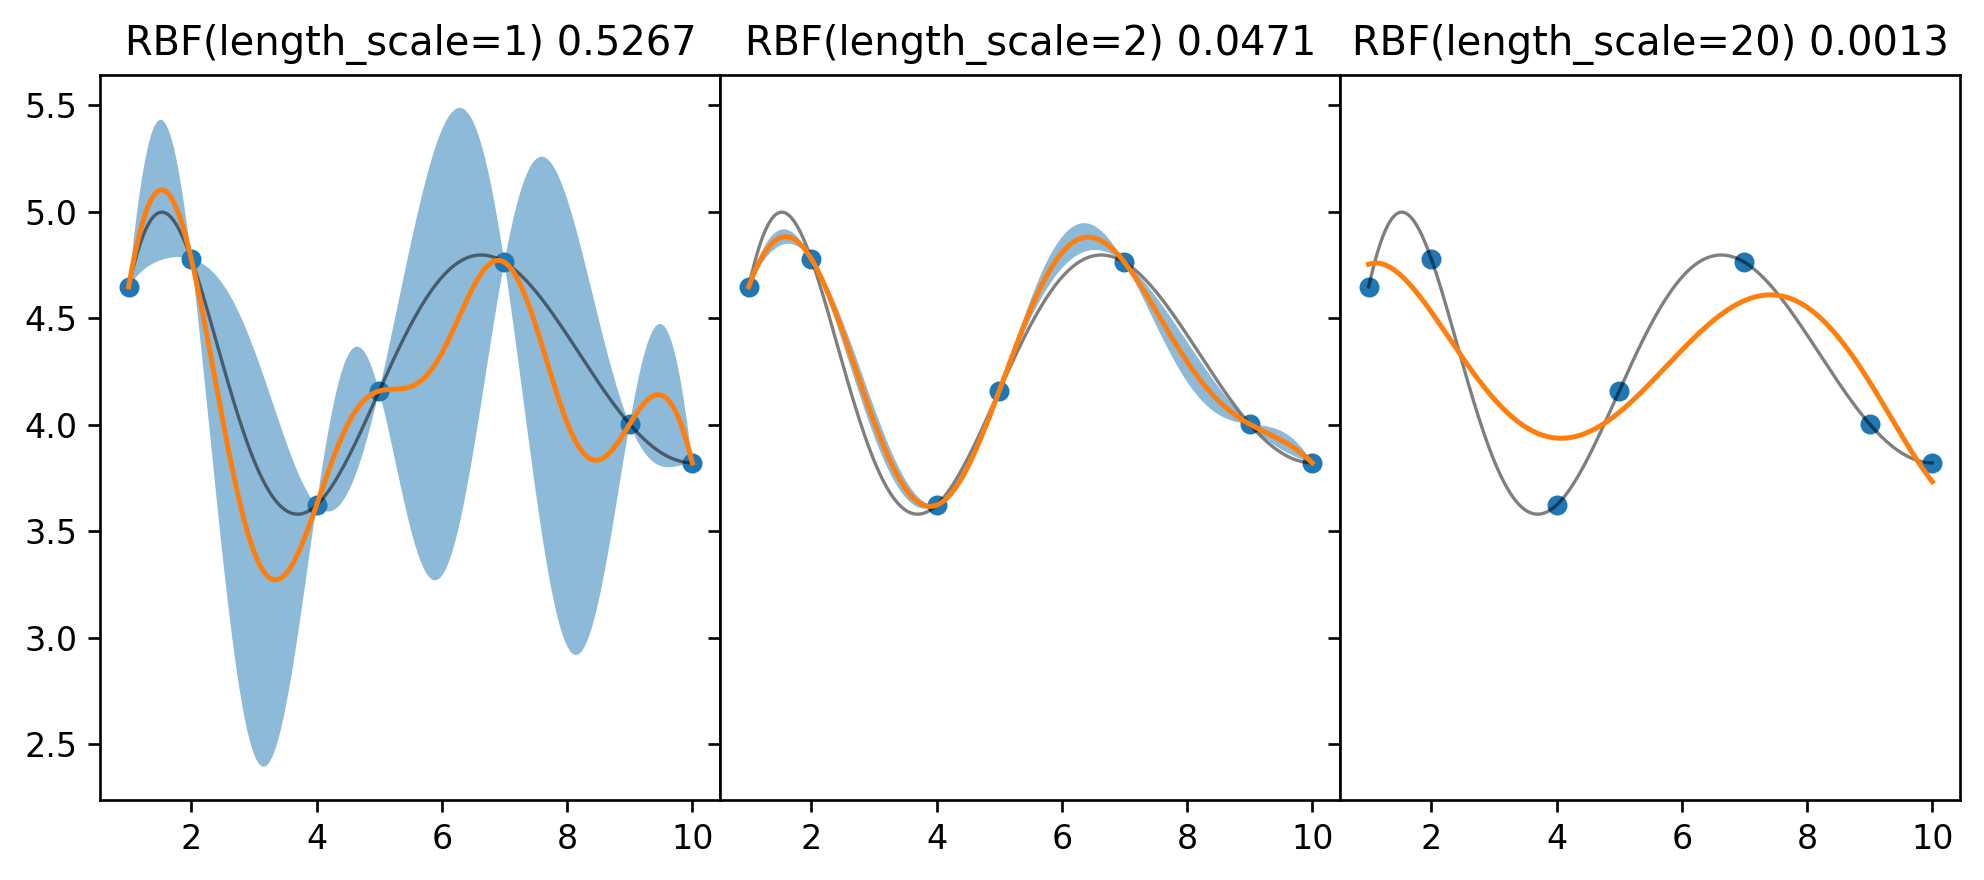

In [13]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernels = [
    RBF(length_scale=1.0, length_scale_bounds=(1.0, 1.01)), 
    RBF(length_scale=2.0, length_scale_bounds=(2.0, 2.01)),
    RBF(length_scale=20.0, length_scale_bounds=(20.0, 20.01)),
]

fig, axes = plt.subplots(figsize=(10, 4), ncols=len(kernels), sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for k, ax in zip(kernels, axes):
    gp = GaussianProcessRegressor(kernel=k)
    gp.fit(np.atleast_2d(xs).T, ys)
    
    y_mean, y_std = gp.predict(x_fine[:, None], return_std=True)

    ax.plot(xs, ys, 'o', label="Samples", markersize=5)
    ax.plot(x_fine, y_fine, label="Function", color="k", ls="-", lw=1, alpha=0.5)
    ax.plot(x_fine, y_mean)
    ax.fill_between(x_fine, y_mean + 2 * y_std, y_mean - 2 * y_std, alpha=0.5)
    ax.set_title(str(k) + f" {y_std.max():0.4f}")
    

You can see on the left we have a model where the length scale is too small. On the right its so large its pulling even the known data points away from where they belond. But the middle looks pretty good.

So we do is fit the hyperparameters to maximise the marginal likelihood conditioned on the hyperparameters. I won't go into the math, but the marginal likelihood has a term for how well it fits to data (so the right hand plot would have a horrible score), a normalisation term, and a penalty for complexity (so the left hand model would be too complex because its scale is too small and allows for too much freedom).

But this is only talking about how to train hyper parameters. There are a ton of different kernels you can pick from, and thats the actual hard task. If you use deep gaussian processes they can do that for you too, but thats well beyond this course.

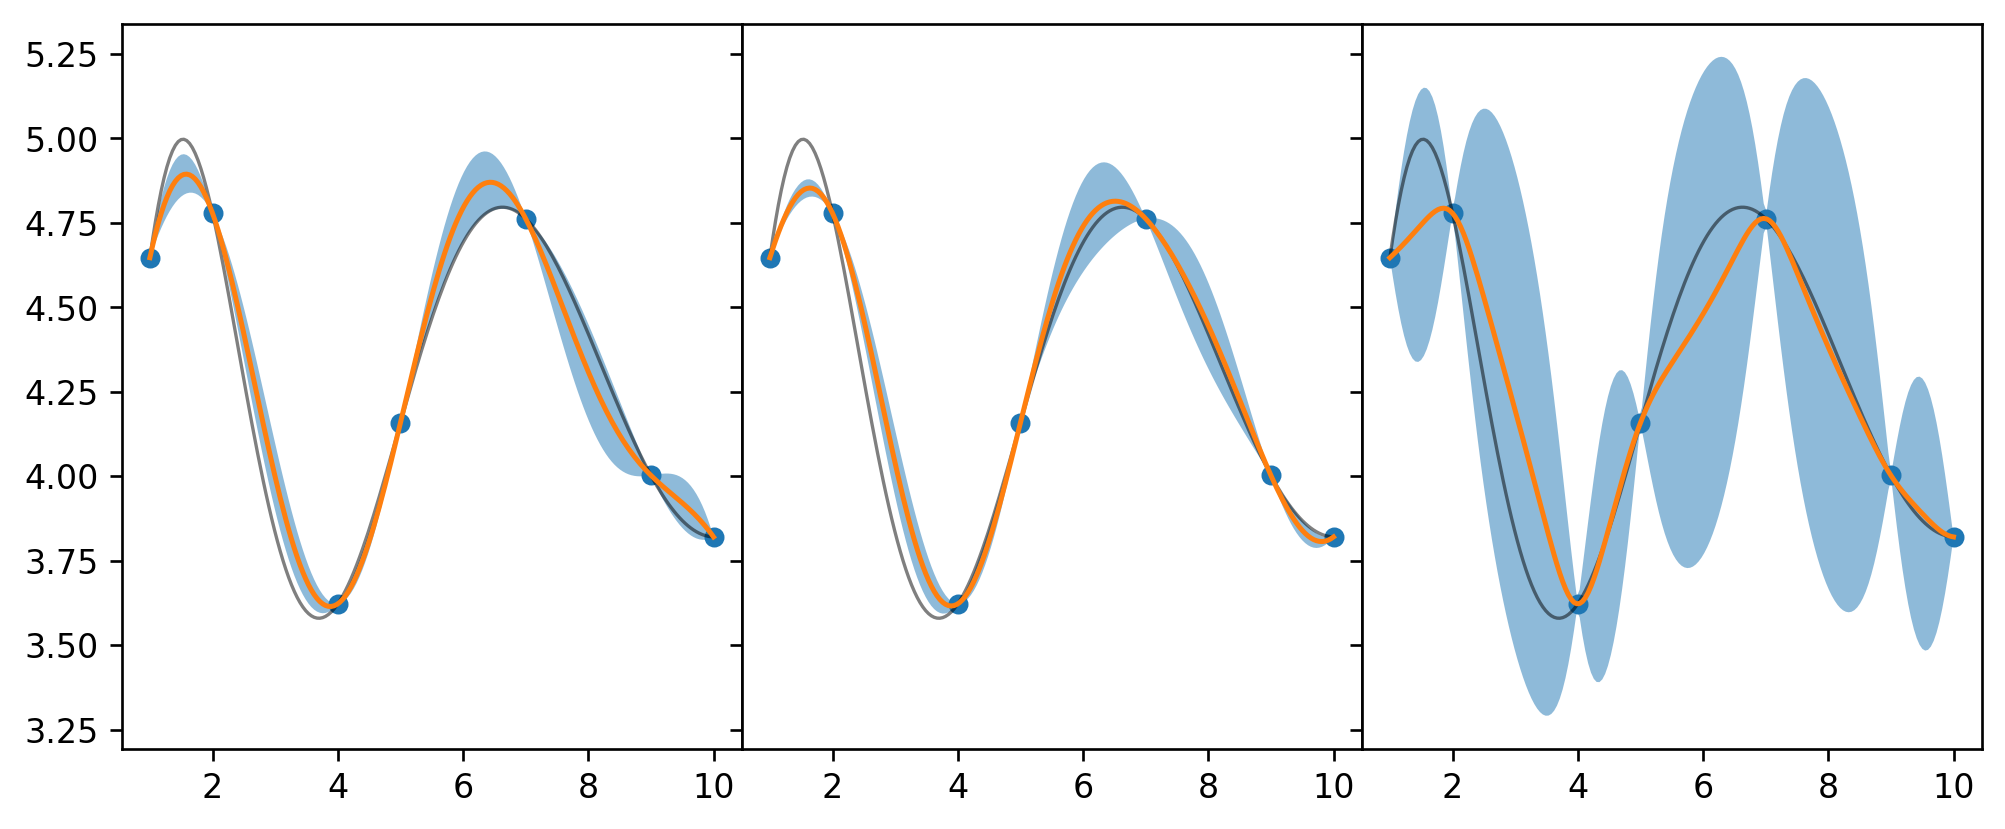

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import ExpSineSquared as ES, RationalQuadratic as RQ

kernels = [
    C() * RBF(), 
    ES(periodicity=10),
    C() * RQ() + RBF()
]

fig, axes = plt.subplots(figsize=(10, 4), ncols=len(kernels), sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for k, ax in zip(kernels, axes):
    gp = GaussianProcessRegressor(kernel=k)
    gp.fit(np.atleast_2d(xs).T, ys)
    
    y_mean, y_std = gp.predict(x_fine[:, None], return_std=True)

    ax.plot(xs, ys, 'o', label="Samples", markersize=5)
    ax.plot(x_fine, y_fine, label="Function", color="k", ls="-", lw=1, alpha=0.5)
    ax.plot(x_fine, y_mean)
    ax.fill_between(x_fine, y_mean + 2 * y_std, y_mean - 2 * y_std, alpha=0.5)


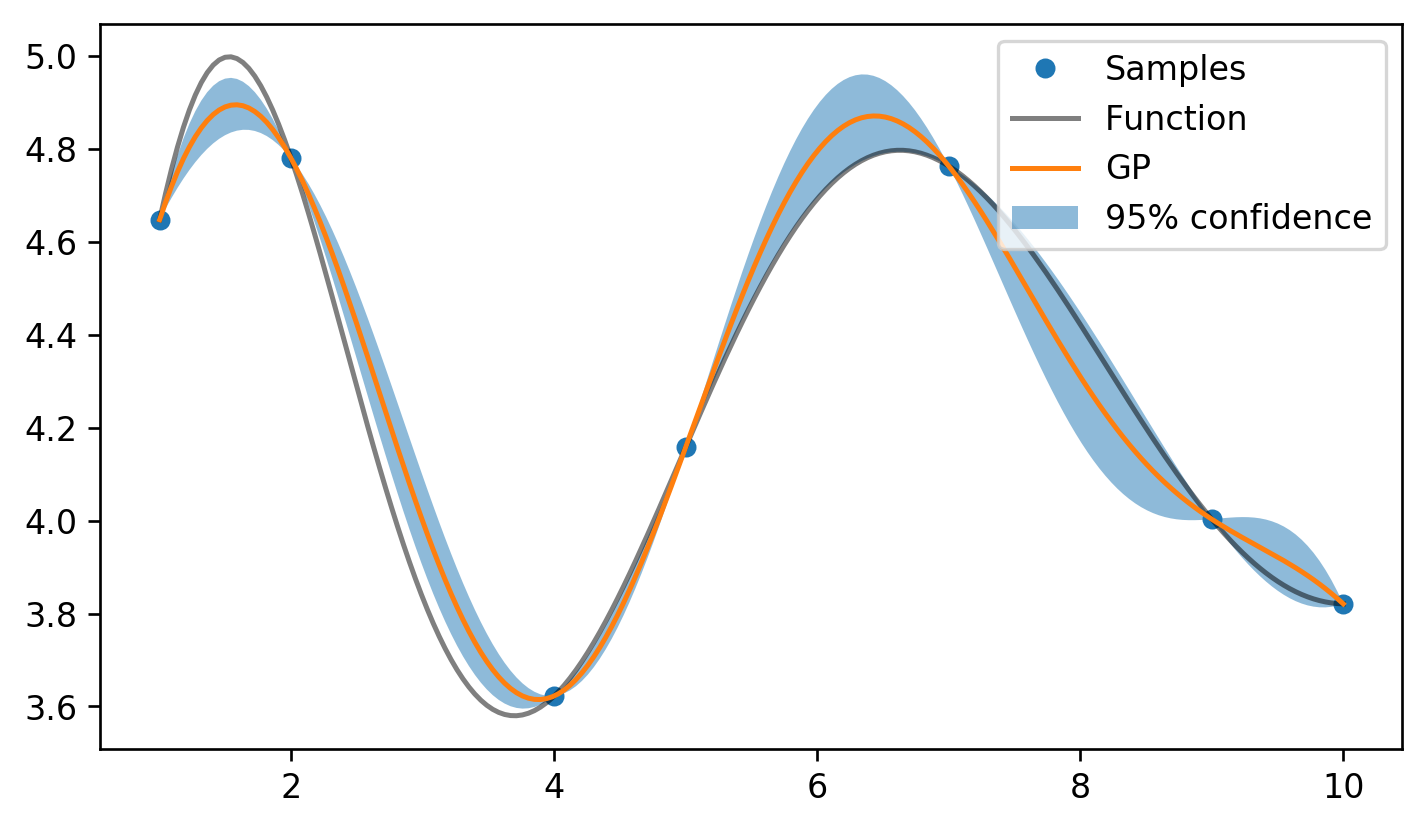

In [17]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

gp = GaussianProcessRegressor(kernel=C() * RBF())
gp.fit(np.atleast_2d(xs).T, ys)
y_pred, sigma = gp.predict(np.atleast_2d(x_fine).T, return_std=True)

upper, lower = y_pred + 1.96 * sigma, y_pred - 1.96 * sigma

plt.plot(xs, ys, 'o', label="Samples", markersize=5)
plt.plot(x_fine, y_fine, label="Function", color="k", ls="-", alpha=0.5)
plt.plot(x_fine, y_pred, label="GP")
plt.fill_between(x_fine, upper, lower, alpha=0.5, label="95% confidence")
plt.legend();

### Gaussian Proccesses with uncertainty

Conceptually, what if our data points have uncertainty. Under the hood, what we're doing is adding in an extra covariance matrix into the mix, where for our independent uncertainty will be a diagonal matrix. Formally, this is called Tikhonov regularization.

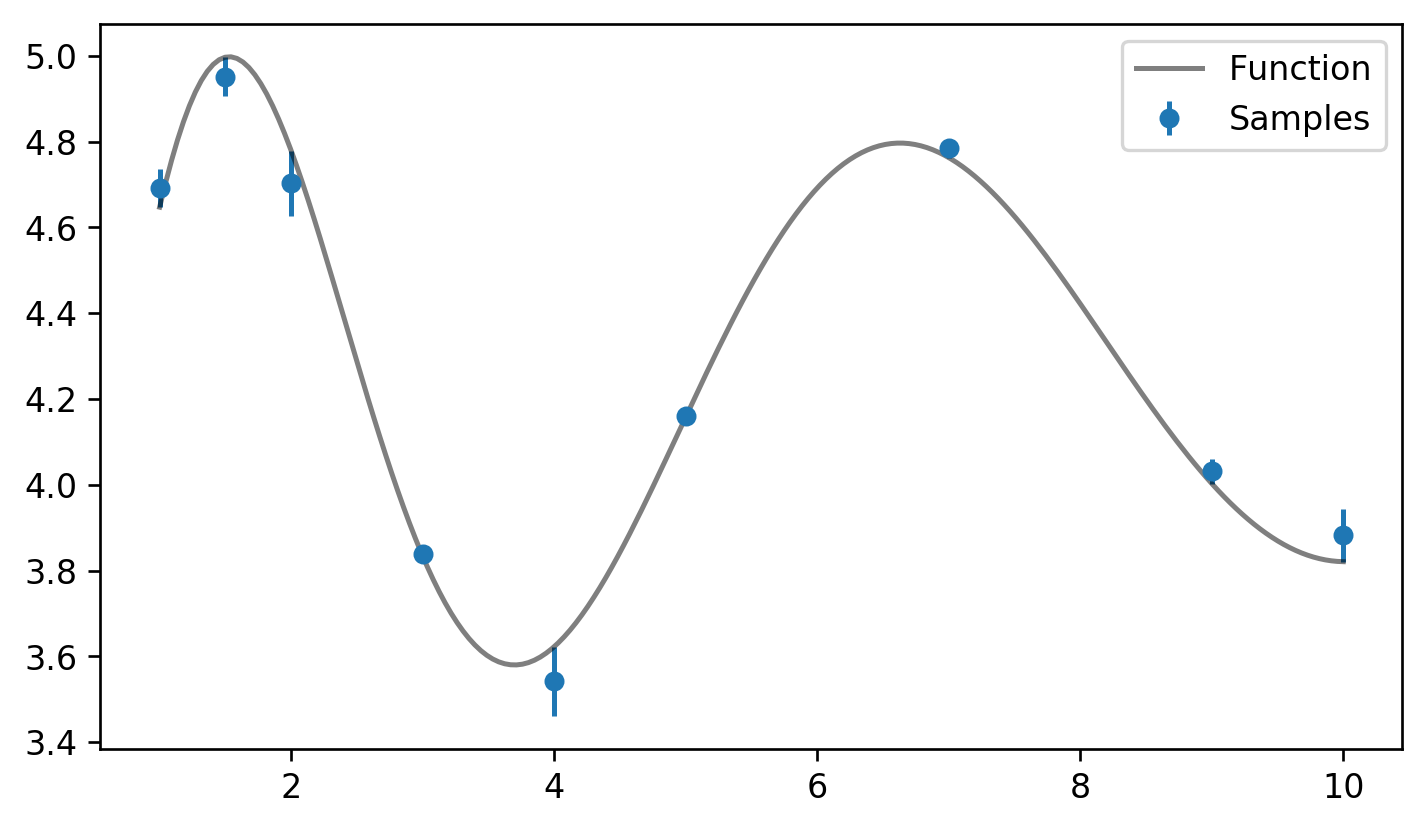

In [19]:
np.random.seed(2)

xs2 = np.array([1, 1.5, 2, 3, 4, 5, 7, 9, 10])
ys2 = fn(xs2)

err_scale = np.random.uniform(low=0.03, high=0.1, size=ys2.shape)
err = np.random.normal(loc=0, scale=err_scale, size=ys2.shape)
ys_err = ys2 + err

plt.errorbar(xs2, ys_err, yerr=err, fmt="o", label="Samples", markersize=5)
plt.plot(x_fine, y_fine, label="Function", color="k", alpha=0.5, linestyle="-")
plt.legend();

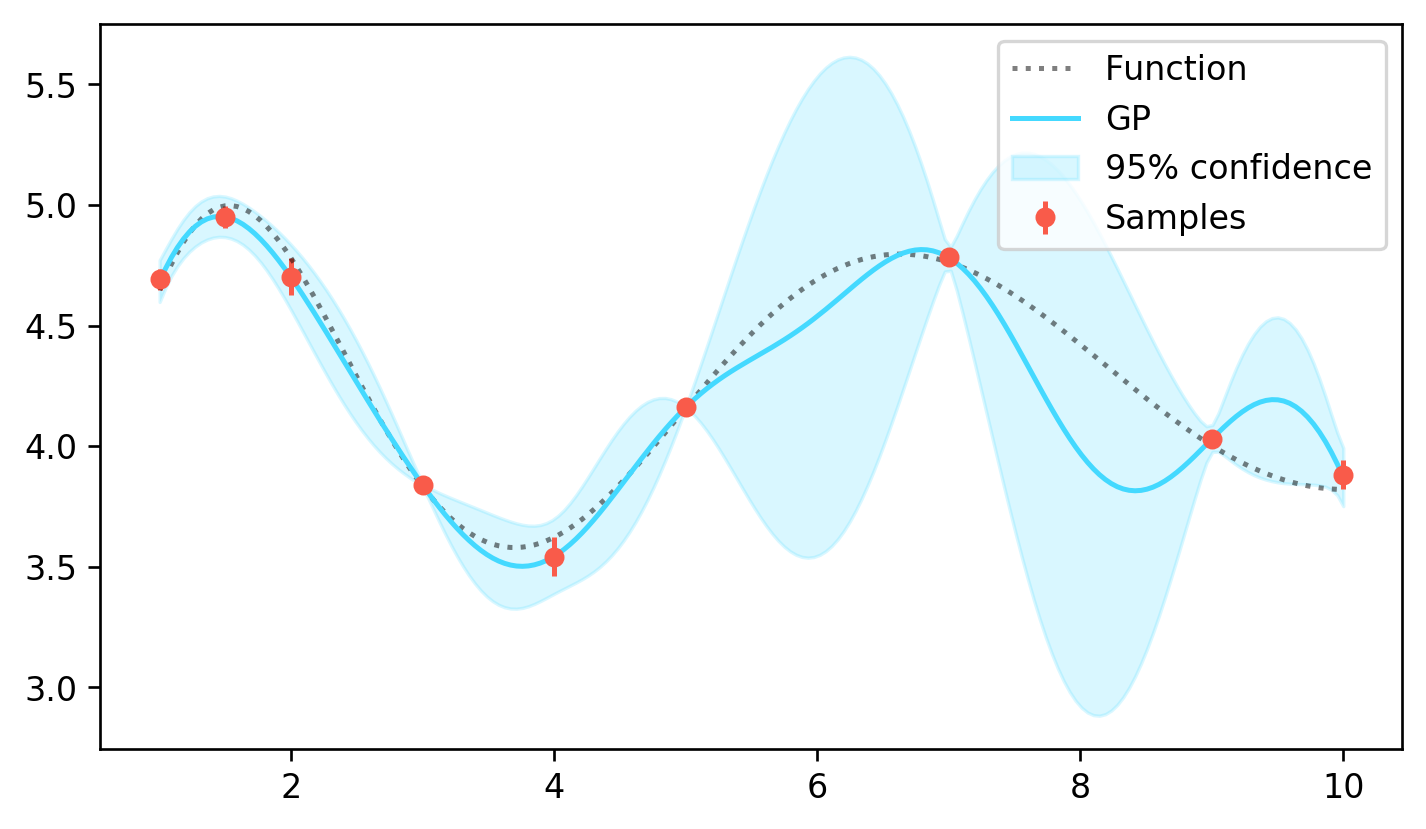

In [21]:
gp = GaussianProcessRegressor(alpha=err**2)
gp.fit(np.atleast_2d(xs2).T, ys_err)
y_pred, sigma = gp.predict(np.atleast_2d(x_fine).T, return_std=True)

upper, lower = y_pred + 1.96 * sigma, y_pred - 1.96 * sigma

plt.errorbar(xs2, ys_err, yerr=err, fmt="o", label="Samples", color="#f95b4a", markersize=5)
plt.plot(x_fine, y_fine, label="Function", color="k", ls=":", alpha=0.5)
plt.plot(x_fine, y_pred, label="GP", color="#44d9ff", ls="-")
plt.fill_between(x_fine, upper, lower, alpha=0.2, color="#44d9ff", label="95% confidence")
plt.legend();

Gaussian proccesses require subtlety in training, especially pickling the right kernel. Its a very deep and rich field that you can easily spend an entire PhD investigating.